# Step 1:
<font size = '5'>The code starts by importing necessary libraries for data manipulation, visualization, and machine learning. It then loads three datasets: a sample submission file (for Kaggle competition format), a test dataset, and a training dataset.</font>

In [276]:
# Import standard libraries (pandas, mathplotlib, seaborn)
# Import specific tools from libraries: sklearn (score validation & tools, regression models)
# xgboost (gradient boosting); scipy(parameters for iteration)
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
import numpy as np
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from scipy.stats import randint, uniform

# Added for better presentation asthetic
import warnings
warnings.filterwarnings('ignore')

# Load datasets
csv_file = "/kaggle/input/ai-x-data-supervised-pillar-spring-2025/sample_submission.csv"
df = pd.read_csv(csv_file)
print(df.head())

dtest = pd.read_csv("/kaggle/input/ai-x-data-supervised-pillar-spring-2025/test.csv")
print(dtest.head())

dtrain = pd.read_csv("/kaggle/input/ai-x-data-supervised-pillar-spring-2025/train.csv")

     id  avg_disbursed_loan
0  1001         2506.205502
1  1002         2506.205502
2  1003         2506.205502
3  1004         2506.205502
4  1005         2506.205502
     id  num_recipients                             school school_type state  \
0  1001            3466  SOUTHERN NEW HAMPSHIRE UNIVERSITY     PRIVATE    NH   
1  1002              79         WISCONSIN LUTHERAN COLLEGE     PRIVATE    WI   
2  1003             681  VOLUNTEER STATE COMMUNITY COLLEGE      PUBLIC    TN   
3  1004             762             UNIVERSITY OF PORTLAND     PRIVATE    OR   
4  1005              34                    RICE UNIVERSITY     PRIVATE    TX   

   zip_code zip_median_household_income degree_length  room_and_board_price  \
0      3106                       84946        4 Year               13120.0   
1     53226                       64390        4 Year               10190.0   
2     37066                       50998        2 Year                   NaN   
3     97203                       4

# Step 2:
<font size='5'>This section handles missing values in both test and training datasets. For numeric columns, missing values are replaced with the median. For categorical columns (object type), missing values are replaced with the mode (most frequent value).</font>

In [277]:
# Handle missing values in test dataset
dtest.fillna(dtest.median(numeric_only=True), inplace=True)
for col in dtest.select_dtypes(include=["object"]).columns:
    dtest[col].fillna(dtest[col].mode()[0], inplace=True)
print("Missing values after imputation:\n", dtest.isna().sum())

# Handle missing values in training dataset
dtrain.fillna(dtrain.median(numeric_only=True), inplace=True)
for col in dtrain.select_dtypes(include=["object"]).columns:
    dtest[col].fillna(dtrain[col].mode()[0], inplace=True)
print("Missing values after imputation:\n", dtrain.isna().sum())

Missing values after imputation:
 id                                           0
num_recipients                               0
school                                       0
school_type                                  0
state                                        0
zip_code                                     0
zip_median_household_income                  0
degree_length                                0
room_and_board_price                         0
in_state_tuition                             0
out_of_state_tuition                         0
early_career_pay_estimate                    0
mid_career_pay_estimate                      0
stem_percent                                 0
total_enrollment                             0
american_indian_alaska_native_enrolled       0
asian_enrolled                               0
black_enrolled                               0
hispanic_enrolled                            0
native_hawaiian_pacific_islander_enrolled    0
non_resident_foreign_enrol

# Step 3:
<font size = '5'>This section visualizes the data for use to understand and see the relationships between variables. It creates scatter plots to see how average disbursed loans vary by school and school type, boxplots to compare loan distributions across school types, and calculates summary statistics for each school type. A histogram also shows the overall distribution of loan amounts.</font>

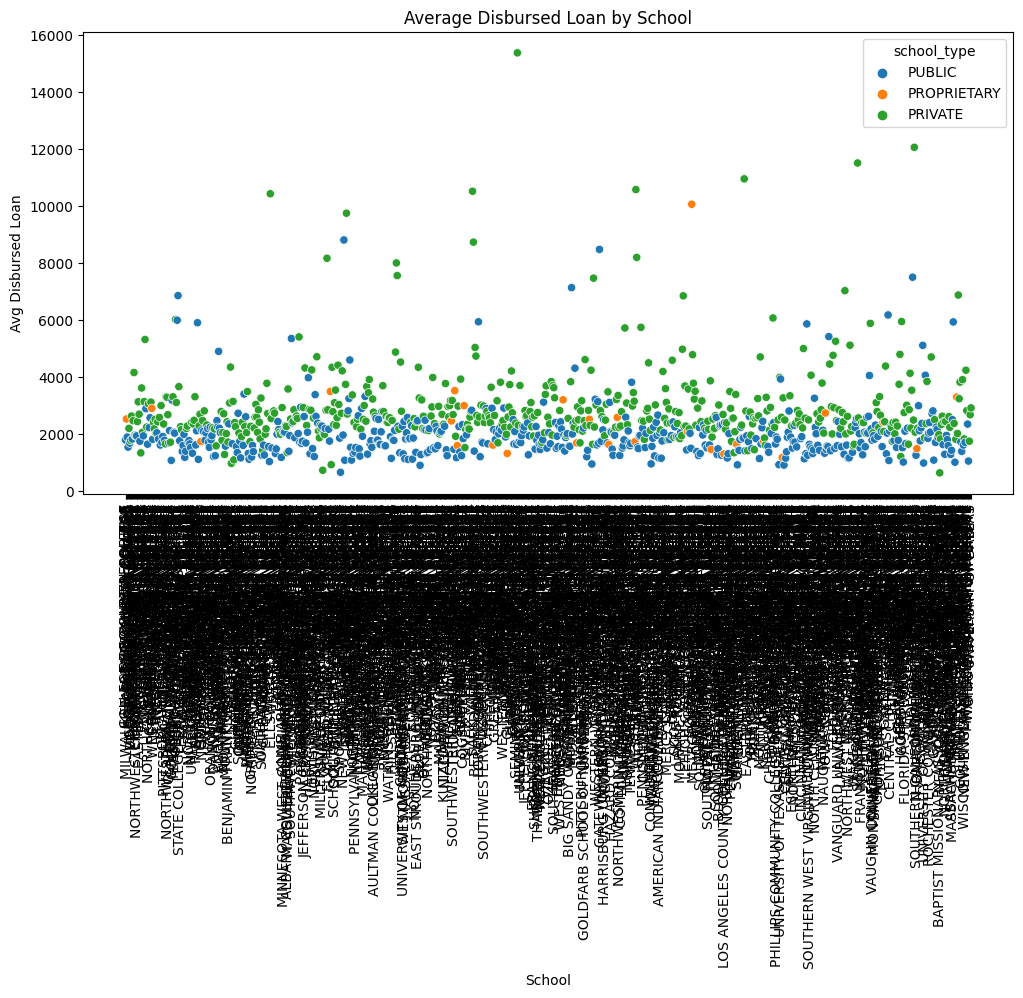

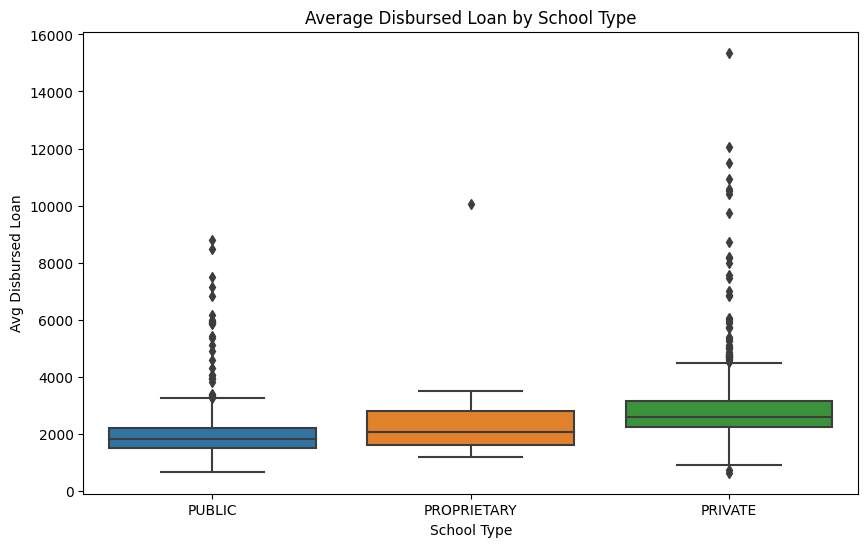

Summary Statistics by School Type:
              count         mean          std          min          25%  \
school_type                                                              
PRIVATE      491.0  2984.610686  1534.345503   647.529412  2252.829328   
PROPRIETARY   27.0  2484.899612  1674.676913  1186.368167  1630.215181   
PUBLIC       482.0  2020.060923   973.065655   667.000000  1516.555713   

                     50%          75%           max  
school_type                                          
PRIVATE      2595.509197  3162.046417  15358.000000  
PROPRIETARY  2089.778396  2826.160402  10054.545455  
PUBLIC       1830.254282  2209.966228   8804.000000  


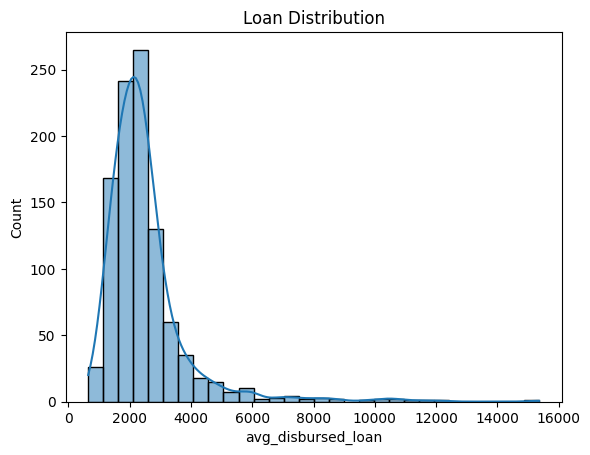

In [278]:
# Scatter plot: Avg disbursed loan by school
plt.figure(figsize=(12, 6))
sns.scatterplot(x=dtrain["school"], y=dtrain["avg_disbursed_loan"], hue=dtrain["school_type"])
plt.title("Average Disbursed Loan by School")
plt.xlabel("School")
plt.ylabel("Avg Disbursed Loan")
plt.xticks(rotation=90)
plt.show()

#Boxplot the features and show the avg disbursed loan by school type
plt.figure(figsize=(10, 6))
sns.boxplot(x=dtrain["school_type"], y=dtrain["avg_disbursed_loan"])
plt.title("Average Disbursed Loan by School Type")
plt.xlabel("School Type")
plt.ylabel("Avg Disbursed Loan")
plt.show()

# Summary statistics for avg disbursed loan by school type
summary_stats = dtrain.groupby("school_type")["avg_disbursed_loan"].describe()
print("Summary Statistics by School Type:\n", summary_stats)

# Histogram of loan distribution
sns.histplot(dtrain["avg_disbursed_loan"], bins=30, kde=True)
plt.title("Loan Distribution")
plt.show()

# Step 4: Feature Creation

<font size = '5'>This function creates new features from existing ones to potentially improve the model's performance. It creates combinations of tuition and career pay estimates, calculates the ratio of tuition to household income, and combines room/board price with enrollment. The code then prepares the feature matrix (X) and target variable (y) for model training. </font>


In [279]:
#Function for making new features, when we call to it
def engineer_features(df):
    #Define list of columns that need to be numeric
    numeric_cols = ["in_state_tuition", "early_career_pay_estimate", "mid_career_pay_estimate",
                    "zip_median_household_income", "room_and_board_price", "total_enrollment"]

    #Make sure the columns are numeric and make sure they are numeric
    for col in numeric_cols:
        if col in df.columns:
            #Convert all the columns to numeric ones, if not make it none
            df[col] = pd.to_numeric(df[col], errors='coerce')

    # Allow new features to be made from what we currently have in our columns
    #For example, if we have in_state_tuition and early_career_pay_estimate then we can make tuition_earlyCareer
    if all(col in df.columns for col in ["in_state_tuition", "early_career_pay_estimate"]):
        df["tuition_earlyCareer"] = df["in_state_tuition"] * df["early_career_pay_estimate"]
    if all(col in df.columns for col in ["in_state_tuition", "mid_career_pay_estimate"]):
        df["tuition_midCareer"] = df["in_state_tuition"] * df["mid_career_pay_estimate"]
    if all(col in df.columns for col in ["in_state_tuition", "zip_median_household_income"]):
        df["tuition_income_ratio"] = df["in_state_tuition"] / (df["zip_median_household_income"] + 1)
    if all(col in df.columns for col in ["room_and_board_price", "total_enrollment"]):
        df["room_board_enrollment"] = df["room_and_board_price"] * df["total_enrollment"]

    #Now we return the dataframe with the new features that we made
    return df

# Prepare the features and the target from the training data
X = train_df.drop(["avg_disbursed_loan", "id"], axis=1, errors="ignore")
y = train_df["avg_disbursed_loan"].values

# Apply our function to make new features for the training set
X = engineer_features(X)
#Prepare the test set and drop ID
X_test = test_df.drop(["id"], axis=1, errors="ignore")
#This is the features engineered for the test set
X_test = engineer_features(X_test)

# Step 5: Model Training and Hyperparameter Tuning

<font size = '5'>This segment splits the data into training and validation sets, creates a custom MSE (Root Mean Squared Error) scoring function, and performs hyperparameter tuning for an XGBoost regression model using RandomizedSearchCV. The hyperparameter search explores different tree depths, learning rates, and sampling strategies to find the best combination.</font>

In [280]:
# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Critical fix: Reset indexes after split and 
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_train = pd.Series(y_train).reset_index(drop=True)
y_val = pd.Series(y_val).reset_index(drop=True)

# MSE Scorer
def mse_metric(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

# RMSE Scorer
def rmse_metric(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))
    
mse_scorer = make_scorer(mse_metric, greater_is_better=False)
rmse_scorer = make_scorer(rmse_metric, greater_is_better=False)

# XGBoost + Randomized Search
xgb_model = XGBRegressor(random_state=42, tree_method="hist")

param_distributions = {
    "n_estimators": randint(100, 300),
    "max_depth": randint(3, 7),
    "learning_rate": uniform(0.05, 0.15),
    "subsample": uniform(0.7, 0.3),
    "colsample_bytree": uniform(0.7, 0.3)
}

cv = KFold(n_splits=3, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_distributions,
    n_iter=10,
    scoring=rmse_scorer,
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

#We do not want to overfit the model so we are setting paramters for early stopping by using an evaluation set and how many rounds if it does not improve
fit_params = {
    "eval_set": [(X_val, y_val)],
    "early_stopping_rounds": 30,
    "verbose": False
}


#FineTuning
#Fit model using RandSearchCV which samples the parameters we have set before
random_search.fit(X_train, y_train, **fit_params)

#Find the best parameter using our search 
#Give us the best model that we had with the different parameters according to our RMSE
print("\nBest Params:", random_search.best_params_)
#Hold the best model 
best_xgb = random_search.best_estimator_

Fitting 3 folds for each of 10 candidates, totalling 30 fits

Best Params: {'colsample_bytree': 0.8199582915145766, 'learning_rate': 0.056999849482042314, 'max_depth': 6, 'n_estimators': 114, 'subsample': 0.8368209952651107}


# Step 6: Model Evaluation

<font size = '5'>The best XGBoost model from the hyperparameter search is evaluated on the validation set. Two metrics are reported: RMSE (lower is better), MSE (lower is better), and R² (higher is better). RMSE measures the average prediction error in the original units, while R² indicates the proportion of variance explained by the model.</font>

In [281]:
# Validation
y_val_pred = best_xgb.predict(X_val) #random search funtion from XGB
#20% of original data for testing

val_rmse = rmse_metric(y_val, y_val_pred)
val_r2 = r2_score(y_val, y_val_pred)

print(f"\nValidation RMSE: {val_rmse:.3f}")
print(f"Validation R^2: {val_r2:.3f}")


Validation RMSE: 996.820
Validation R^2: 0.568


# Step 7: Feature Analysis

<font size =5>This section analyzes the importance of each feature in the trained XGBoost model. Features with very low importance (< 0.0001) are identified and optionally removed from the dataset to simplify the model.</font>


In [282]:
# Feature importances
importances = best_xgb.feature_importances_
imp_series = pd.Series(importances, index=X_train.columns).sort_values(ascending=False)
print("\nTop 20 Features by Importance:")
print(imp_series.head(20))

#best_xgb.feature_importances_ retrieves the importance scores
#of each feature.
#These scores indicate how much each feature contributes 
#to the model’s predictions.
#Higher values = more important features; lower values = less useful features.

# Optional: drop low-importance features
low_importance = imp_series[imp_series < 1e-4].index
if len(low_importance) > 0:
    print("\nDropping these near-zero-importance features:", list(low_importance))
    X_train = X_train.drop(columns=low_importance, errors="ignore")
    X_val = X_val.drop(columns=low_importance, errors="ignore")
    X_test = X_test.drop(columns=low_importance, errors="ignore")


Top 20 Features by Importance:
early_career_pay_estimate        0.130216
room_and_board_price             0.117836
out_of_state_tuition             0.079290
mid_career_pay_estimate          0.062804
total_enrollment                 0.048605
total_minority_enrolled          0.046198
num_recipients                   0.044600
non_resident_foreign_enrolled    0.037665
room_board_enrollment            0.037039
in_state_tuition                 0.031769
tuition_income_ratio             0.031080
unknown_enrolled                 0.030572
asian_enrolled                   0.028364
tuition_earlyCareer              0.025488
women_enrolled                   0.025016
black_enrolled                   0.023577
tuition_midCareer                0.023540
stem_percent                     0.020685
hispanic_enrolled                0.018920
zip_median_household_income      0.017457
dtype: float32

Dropping these near-zero-importance features: ['county_name', 'degree_length', 'school_type', 'state', 'school']

# Step 8: Final Model Training and Prediction

<font size = '5'>This final section combines the training and validation sets to train the model on all available data. It also creates an ensemble model by averaging predictions from XGBoost and Random Forest models, which often yields better performance than either model alone. The ensemble is evaluated on the validation set, and then used to generate predictions for the test set. Finally, a submission file is created for the Kaggle competition.</font>


In [283]:
# Retrain on all data
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_val.reset_index(drop=True, inplace=True)

X_combined = pd.concat([X_train, X_val], ignore_index=True)
y_combined = pd.concat([y_train, y_val], ignore_index=True)

best_xgb.fit(
    X_combined, 
    y_combined,
    early_stopping_rounds=30,
    eval_set=[(X_combined, y_combined)],
    verbose=False
)

# Optional ensemble
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_combined, y_combined)

y_val_pred_xgb = best_xgb.predict(X_val)
y_val_pred_rf = rf.predict(X_val)
y_val_pred_ensemble = 0.5 * y_val_pred_xgb + 0.5 * y_val_pred_rf

ensemble_rmse = rmse_metric(y_val, y_val_pred_ensemble)
#measures the average magnitude of errors 
#(how far predictions are from actual values) 
#in the same unit as the target variable.
ensemble_r2 = r2_score(y_val, y_val_pred_ensemble)

print(f"\nEnsemble RMSE: {ensemble_rmse:.3f}")
print(f"Ensemble R^2: {ensemble_r2:.3f}")

# Final predictions
y_test_pred_xgb = best_xgb.predict(X_test)
y_test_pred_rf = rf.predict(X_test)
y_test_pred_ensemble = 0.5 * y_test_pred_xgb + 0.5 * y_test_pred_rf

submission = pd.DataFrame({
    "id": dtest["id"],
    "avg_disbursed_loan": y_test_pred_ensemble
})
submission.to_csv("submission.csv", index=False)
print("Saved submission.csv")
print(submission)


Ensemble RMSE: 284.982
Ensemble R^2: 0.965
Saved submission.csv
       id  avg_disbursed_loan
0    1001         3435.385078
1    1002         2444.875243
2    1003         1684.284834
3    1004         4229.232943
4    1005         5080.319774
..    ...                 ...
248  1249         2172.563672
249  1250         1626.526428
250  1251         4682.736383
251  1252         1613.604530
252  1253         1560.783498

[253 rows x 2 columns]
